# Deep Learning on Default Payments Information in Taiwan 2005
## Assignment 1 - Fabrizio Olivadese
The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005. 

The provided data comprises the training set that can be used for the training (and eventually for the validation) and the unlabelled test set.

In [111]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [112]:
!pip install keras-metrics

import keras
import keras_metrics

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import math

# Carico i dati
Carico i dati e  visualizo l'head del traning set per fami un idea di come è costituito il dataset

In [113]:
train=pd.read_csv("drive/My Drive/Colab Notebooks/Assignment 1/train.csv") #Questo Path è da cambiare se non viene eseguito sul mio Colab
test=pd.read_csv("drive/My Drive/Colab Notebooks/Assignment 1/test.csv")
#train=pd.read_csv("train/test.csv") #Probabilmente sarà così se lo eseguo in locale
train.head(10)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
5,50000.0,1,1,2,37,0,0,0,0,0,0,64400.0,57069.0,57608.0,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0
6,500000.0,1,1,2,29,0,0,0,0,0,0,367965.0,412023.0,445007.0,542653.0,483003.0,473944.0,55000.0,40000.0,38000.0,20239.0,13750.0,13770.0,0
7,100000.0,2,2,2,23,0,-1,-1,0,0,-1,11876.0,380.0,601.0,221.0,-159.0,567.0,380.0,601.0,0.0,581.0,1687.0,1542.0,0
8,140000.0,2,3,1,28,0,0,2,0,0,0,11285.0,14096.0,12108.0,12211.0,11793.0,3719.0,3329.0,0.0,432.0,1000.0,1000.0,1000.0,0
9,20000.0,1,3,2,35,-2,-2,-2,-2,-1,-1,0.0,0.0,0.0,0.0,13007.0,13912.0,0.0,0.0,0.0,13007.0,1122.0,0.0,0


L'attributo da predirre (ultima colonna) è **binario**

Ho pensato che i valori <0 di pay potessero essere errati per qualche ragione e li ho settati a 0 per vedere se le performance miglioravano.

In realtà, andando sulla documentazione del dataset presente su kaggle, i valori minori di zero sono ammessi e si intende che il pagamento è in anticipo.

Lascio comunque commentato il codice per settare a zero i valori di pay <0

In [114]:
'''train[train['PAY_0'] < 0]['PAY_0'] = 0
train[train['PAY_2'] < 0]['PAY_2'] = 0
train[train['PAY_3'] < 0]['PAY_3'] = 0
train[train['PAY_4'] < 0]['PAY_4'] = 0
train[train['PAY_5'] < 0]['PAY_5'] = 0
train[train['PAY_6'] < 0]['PAY_6'] = 0

test[test['PAY_0'] < 0]['PAY_0'] = 0
test[test['PAY_2'] < 0]['PAY_2'] = 0
test[test['PAY_3'] < 0]['PAY_3'] = 0
test[test['PAY_4'] < 0]['PAY_4'] = 0
test[test['PAY_5'] < 0]['PAY_5'] = 0
test[test['PAY_6'] < 0]['PAY_6'] = 0'''

"train[train['PAY_0'] < 0]['PAY_0'] = 0\ntrain[train['PAY_2'] < 0]['PAY_2'] = 0\ntrain[train['PAY_3'] < 0]['PAY_3'] = 0\ntrain[train['PAY_4'] < 0]['PAY_4'] = 0\ntrain[train['PAY_5'] < 0]['PAY_5'] = 0\ntrain[train['PAY_6'] < 0]['PAY_6'] = 0\n\ntest[test['PAY_0'] < 0]['PAY_0'] = 0\ntest[test['PAY_2'] < 0]['PAY_2'] = 0\ntest[test['PAY_3'] < 0]['PAY_3'] = 0\ntest[test['PAY_4'] < 0]['PAY_4'] = 0\ntest[test['PAY_5'] < 0]['PAY_5'] = 0\ntest[test['PAY_6'] < 0]['PAY_6'] = 0"

In [115]:
train.shape

(27000, 24)

Ho **27.000 record con 24 feature** - nel traning set

In [116]:
test.shape

(3000, 23)

Ho **3000 record con 23 feature** (la colonna da predirre è già mancante) - nel test set

# Alcuni test sul dataset

Voglio verificare se il dataset è sbilanciato poichè dall'header stampato sopra mi sembra che lo possa essere

In [117]:
from collections import Counter
count = Counter(train['default.payment.next.month'].values)
count

Counter({0: 21027, 1: 5973})

Si, è sbilanciato sull'attributo da predirre. 

21.027 -> 0

5.973 -> 1

Provando comunque a bilanciarlo non cambia di molto, anche perchè già così il modello NON predice tutti 1

# Binarizzazione degli attributi categorici

Binarizzo Education, Marriage, Sex e tutti gli attributi PAY.



In [118]:
#Categorizzazione degli attributi categorici del traning set. 
# Li lascio tutti singoli così posso provare a commentarne alcuni per vedere se le performance variano togliendo alcune binarizzazioni
train = pd.concat([train,pd.get_dummies(train['EDUCATION'], prefix='EDUCATION',drop_first=False)],axis=1).drop(['EDUCATION'],axis=1)
train = pd.concat([train,pd.get_dummies(train['MARRIAGE'], prefix='MARRIAGE',drop_first=False)],axis=1).drop(['MARRIAGE'],axis=1)
train = pd.concat([train,pd.get_dummies(train['SEX'], prefix='SEX',drop_first=False)],axis=1).drop(['SEX'],axis=1)
train = pd.concat([train,pd.get_dummies(train['PAY_0'], prefix='PAY_0',drop_first=False)],axis=1).drop(['PAY_0'],axis=1)
train = pd.concat([train,pd.get_dummies(train['PAY_2'], prefix='PAY_2',drop_first=False)],axis=1).drop(['PAY_2'],axis=1)
train = pd.concat([train,pd.get_dummies(train['PAY_3'], prefix='PAY_3',drop_first=False)],axis=1).drop(['PAY_3'],axis=1)
train = pd.concat([train,pd.get_dummies(train['PAY_4'], prefix='PAY_4',drop_first=False)],axis=1).drop(['PAY_4'],axis=1)
train = pd.concat([train,pd.get_dummies(train['PAY_5'], prefix='PAY_5',drop_first=False)],axis=1).drop(['PAY_5'],axis=1)
train = pd.concat([train,pd.get_dummies(train['PAY_6'], prefix='PAY_6',drop_first=False)],axis=1).drop(['PAY_6'],axis=1)

#Categorizzazione degli attributi categorici del test set (devono essere uguali, quindi devo binarizzare nello stesso modo anche quelli)
test = pd.concat([test,pd.get_dummies(test['EDUCATION'], prefix='EDUCATION',drop_first=False)],axis=1).drop(['EDUCATION'],axis=1)
test = pd.concat([test,pd.get_dummies(test['MARRIAGE'], prefix='MARRIAGE',drop_first=False)],axis=1).drop(['MARRIAGE'],axis=1)
test = pd.concat([test,pd.get_dummies(test['SEX'], prefix='SEX',drop_first=False)],axis=1).drop(['SEX'],axis=1)
test = pd.concat([test,pd.get_dummies(test['PAY_0'], prefix='PAY_0',drop_first=False)],axis=1).drop(['PAY_0'],axis=1)
test = pd.concat([test,pd.get_dummies(test['PAY_2'], prefix='PAY_2',drop_first=False)],axis=1).drop(['PAY_2'],axis=1)
test = pd.concat([test,pd.get_dummies(test['PAY_3'], prefix='PAY_3',drop_first=False)],axis=1).drop(['PAY_3'],axis=1)
test = pd.concat([test,pd.get_dummies(test['PAY_4'], prefix='PAY_4',drop_first=False)],axis=1).drop(['PAY_4'],axis=1)
test = pd.concat([test,pd.get_dummies(test['PAY_5'], prefix='PAY_5',drop_first=False)],axis=1).drop(['PAY_5'],axis=1)
test = pd.concat([test,pd.get_dummies(test['PAY_6'], prefix='PAY_6',drop_first=False)],axis=1).drop(['PAY_6'],axis=1)


#La binarizzazione automatica sul test set non include tutte le colonne presenti sul traning perchè non avendo tutti i valori alcune colonne non vengono create.
#Per però ovviare a questo problema le creo manualmente (quelle mancanti) e le setto a 0.
test['PAY_0_6'] = 0
test['PAY_0_7'] = 0
test['PAY_0_8'] = 0
test['PAY_2_5'] = 0
test['PAY_2_7'] = 0
test['PAY_2_8'] = 0
test['PAY_3_1'] = 0
test['PAY_3_6'] = 0
test['PAY_3_8'] = 0
test['PAY_4_1'] = 0
test['PAY_4_6'] = 0
test['PAY_4_8'] = 0
test['PAY_5_6'] = 0
test['PAY_5_8'] = 0
test['PAY_6_5'] = 0
test['PAY_6_6'] = 0
test['PAY_6_8'] = 0
test['PAY_6_8'] = 0

#Ora però le colonne di tran e test hanno ordinamento diverso: le ordino entrambe alfabeticamente così ritornano ad essere ordinate uguali.
test = test.reindex(sorted(test.columns), axis=1)
train = train.reindex(sorted(train.columns), axis=1)

train.head()

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,LIMIT_BAL,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-1,PAY_0_-2,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-1,PAY_2_-2,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,...,PAY_4_-1,PAY_4_-2,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_-2,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,default.payment.next.month
0,24,3913.0,3102.0,689.0,0.0,0.0,0.0,0,0,1,0,0,0,0,20000.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,689.0,0.0,0.0,0.0,0.0,0,1,1
1,26,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0,0,1,0,0,0,0,120000.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,0,1,1
2,34,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,0,0,1,0,0,0,0,90000.0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,1,0
3,37,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,0,0,1,0,0,0,0,50000.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,1,0
4,57,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,0,0,1,0,0,0,0,50000.0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,1,0,0


In [119]:
train.head(1)

,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,LIMIT_BAL,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,PAY_0_-1,PAY_0_-2,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-1,PAY_2_-2,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,...,PAY_4_-1,PAY_4_-2,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-1,PAY_5_-2,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-1,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_1,SEX_2,default.payment.next.month
0,24,3913.0,3102.0,689.0,0.0,0.0,0.0,0,0,1,0,0,0,0,20000.0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,689.0,0.0,0.0,0.0,0.0,0,1,1


# Eliminazione della classe da predirre dal Dataset

Seleziono la colonna della classe da predirre e la metto in train_label

La rimuovo inoltre dal DS che verrà usato per il traning.


Sul test set non ho bisogno della rimozione perchè la classe da predirre non è presente già di suo

In [0]:
train_data=train.drop('default.payment.next.month', axis=1).values

train_label=train['default.payment.next.month'].values

# Standardizzazione degli attributi


In [0]:
# Funzioni utili
def preprocess_data(X, scaler=None):
    """Preprocess input data by standardise features 
    by removing the mean and scaling to unit variance"""
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(X)
    X = scaler.transform(X)
    return X, scaler


In [122]:
train_data_fixed, scaler1 = preprocess_data(train_data) #normalizzo dati train
test_data_fixed, scaler2 = preprocess_data(test) #normalizzo dati test

print(train_data_fixed[0:2])
train_data_fixed.shape


#ritrasofrmo in dataframe
#training_norm_col = pd.DataFrame(norm_train_data_complete, index=train_data.index, columns=train_data.columns) 
#train.update(training_norm_col)
#train.head(8)

[[-1.2455285  -0.64480547 -0.64788451 -0.66816186 -0.67195561 -0.66291524
  -0.65371556 -0.02194797 -0.73870396  1.06721727 -0.44291336 -0.06337243
  -0.09745126 -0.03947124 -1.13810392 -0.04220123  1.09158529 -1.06404707
  -0.1051029  -0.4843221  -0.31852217 -0.98266868 -0.3735358   3.20890497
  -0.1047421  -0.05061722 -0.03044313 -0.02018845 -0.01490878 -0.02653675
  -0.50225594 -0.37860414 -1.0512369  -0.0316386   2.57515634 -0.1047421
  -0.05750824 -0.03044313 -0.01826046 -0.02722664 -0.00608592  2.01141389
  -0.39605796 -1.05358169 -0.01217251 -0.38083877 -0.09042919 -0.05134747
  -0.0258285  -0.02919894 -0.0310466  -0.01054151  2.07398025 -0.41181385
  -1.10364102 -0.00860695 -0.34285517 -0.0788903  -0.04874425 -0.0339038
  -0.01360954 -0.04476615 -0.00860695 -0.47567785  2.36401772 -1.1383841
  -0.30969768 -0.07841356 -0.05347904 -0.02435044 -0.01217251 -0.04476615
  -0.00608592 -0.4849048   2.26022063 -1.09011979 -0.31852217 -0.08007005
  -0.03993912 -0.02194797 -0.02653675 -0.

(27000, 91)

Non semra essere un problema aver standardizzato anche i valori binarizzati poichè rimangono costanti

# Creo i dati di Validazione

In [123]:
print("Prima della creazione del validation set:")
print("Train data shape: ", train_data.shape)
print("Test data shape: ", test.shape)

#Creo il dataset per la validazione, splittando il traning
train_data, val_data, train_target, val_target= train_test_split(train_data_fixed, train_label, test_size=0.15, random_state=42)

print("\nDopo della creazione del validation set:")
print("Train data shape: ", train_data.shape)
print("Validation data shape: ", val_data.shape)
print("Test data shape: ", test.shape)


Prima della creazione del validation set:
Train data shape:  (27000, 91)
Test data shape:  (3000, 91)

Dopo della creazione del validation set:
Train data shape:  (22950, 91)
Validation data shape:  (4050, 91)
Test data shape:  (3000, 91)


# Definisco e compilo il modello

In [124]:
print(train_data)
dims = train_data.shape[1]
print(dims)

model = Sequential() 
model.add(Dense(128, activation='relu',input_shape=(dims,) ))
model.add(Dense(64, activation='relu')) 
model.add(Dense(1)) 
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam',  
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()]) #prima di eseguire il learning compilo il processo di learning settato prima
model.summary()

[[-0.91966349 -0.11641623 -0.09485196 ... -0.21151489 -0.81108918
   0.81108918]
 [ 0.60103992  0.82420121  0.81520605 ... -0.05085793 -0.81108918
   0.81108918]
 [-1.2455285  -0.21051741 -0.17930264 ... -0.19491238 -0.81108918
   0.81108918]
 ...
 [-0.91966349 -0.52261945 -0.50199981 ... -0.28899328  1.23291005
  -1.23291005]
 [-0.4851768   0.52540037  0.57302509 ... -0.12296817 -0.81108918
   0.81108918]
 [-0.59379847 -0.63709404 -0.57370561 ... -0.26132243 -0.81108918
   0.81108918]]
91
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               11776     
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 65        
_____________________

# Traning del modello

In [125]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stop = EarlyStopping(monitor='val_loss', patience=1, verbose=1) #Imposto che le epoche si fermino quando val_loss smette di migliorare 

history_dieci = model.fit(train_data, train_target, validation_data = (val_data, val_target),
                    epochs=10, batch_size=100, verbose=True, callbacks=[early_stop])

Train on 22950 samples, validate on 4050 samples
Epoch 1/10
22950/22950 [==============================] - 1s 30us/step - loss: 0.4560 - acc: 0.8121 - precision: 0.6423 - recall: 0.3260 - val_loss: 0.4394 - val_acc: 0.8215 - val_precision: 0.7051 - val_recall: 0.3869
Epoch 2/10
22950/22950 [==============================] - 0s 21us/step - loss: 0.4327 - acc: 0.8226 - precision: 0.6854 - recall: 0.3554 - val_loss: 0.4376 - val_acc: 0.8178 - val_precision: 0.7201 - val_recall: 0.3419
Epoch 3/10
22950/22950 [==============================] - 0s 20us/step - loss: 0.4266 - acc: 0.8230 - precision: 0.6897 - recall: 0.3528 - val_loss: 0.4379 - val_acc: 0.8210 - val_precision: 0.7072 - val_recall: 0.3805
Epoch 00003: early stopping


# Performance del Modello sui dati di traning

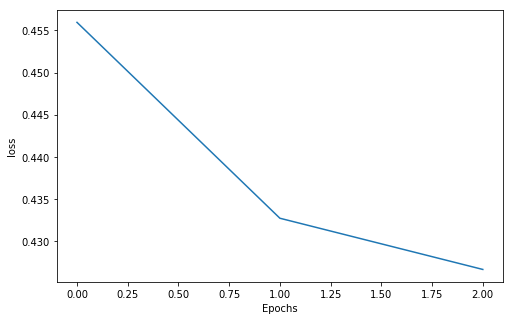

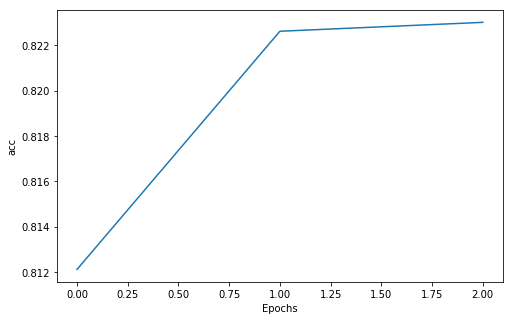

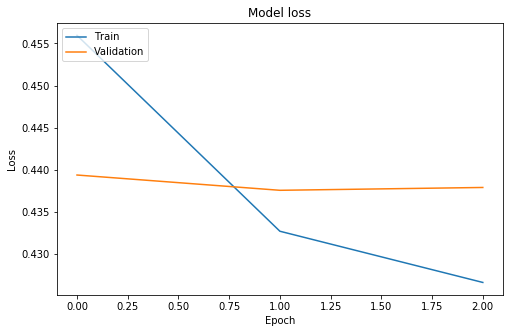

In [126]:
def plot_history(network_history, index):
    plt.figure(figsize=(8,5)) 
    plt.xlabel('Epochs')
    plt.ylabel(index)
    plt.plot(network_history.history[index])

    plt.show()
    
def plot_train_vs_validate(history):
    plt.figure(figsize=(8,5))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_history(history_dieci, 'loss')
plot_history(history_dieci, 'acc')
plot_train_vs_validate(history_dieci)

Noto che dalla 3a epoca in avanti la loss della validation tende a salire.
Questo non va bene, probabilmente sto iniziando ad overfittare. 

**Meglio fermarsi alla 3a epoca,** infatti qui lo faccio di 3 epoche perchè ho già provato a farne di più

## Senza binarizzazione degli attributi

Senza binarizzare gli attributi precedentemente binatizzati (SEX, MARRIAGE, EDUCATION e tutti gli attributi PAY)

**La differenza nelle misure di performance è bassa.**

Il plot seguente riguarda l'accuracy media rilevata su 5 misurazioni con e senza binarizzazione


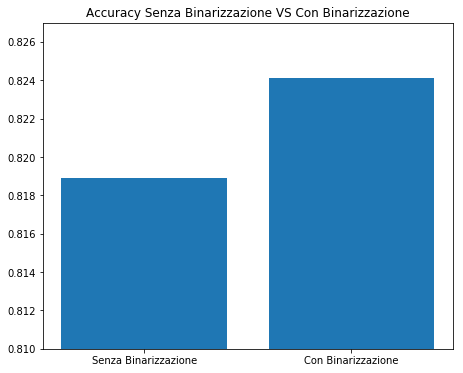

In [127]:
values = [0.8189, 0.8241]
names = ['Senza Binarizzazione', 'Con Binarizzazione']

plt.figure(figsize=(25, 6))

plt.subplot(131)
plt.bar(names, values)
axes = plt.gca()
axes.set_ylim([0.81,0.827])
plt.title('Accuracy Senza Binarizzazione VS Con Binarizzazione')
plt.show()

## Matrice di Confusione del modello sui dati di train

In [128]:
y_pred=model.predict(train_data)
y_pred =(y_pred>0.5)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_target, y_pred)
print(cm)

[[17126   784]
 [ 3198  1842]]


# Esecuzione del modello sui dati di test

In [129]:
predictions = model.predict(test_data_fixed)
predictions =(predictions>0.5)

count = Counter(predictions[:,0])
count


Counter({False: 2668, True: 332})

In [0]:
#Non posso valutare le perfomance sui dati di test poichè non ho le label
#score = model.evaluate(test_data_fixed, train_target, batch_size=100) #evaluating the models accuracy or loss,
#print('test loss, test acc:', score)

In [0]:
with open("Fabrizio_Olivadese_820864_score1.txt", 'w') as f:
    for row in predictions:
      if row:
        f.write("1")
      else:
        f.write("0")
      f.write('\n')